# Regressão Linear Múltipla

O objetivo deste notebook é explorar a regressão múltipla e engenharia de atributos com as funções da API Scikit-learn.

Neste notebook você irá manipular dados de transações imobiliárias de King County para prever preços usando regressão múltipla. Desta forma, você poderá:
* Usar Pandas DataFrames para realizar algumas atividades de engenharia de atributos
* Usar funções do Scikit-learn para computar os coeficientes de regressão (pesos/parâmetros)
* Dados os coeficientes de regressão, os preditores e a saída (preços), criar uma função para computar erro utilizando a técnica de mínimos quadrados (Residual Sum of Squares).
* Visualizar os coeficientes e interpretar seus significados

## Importação das bibliotecas

Importação de bibliotecas necessárias para a execução dos comandos:
* Pandas: para manipulação dos dados
* Numpy: para compatibilizar o uso de dados por algumas funções
* Datetime: para formatar um dos atributos da base de dados
* Sklearn: para uso comparativo de funções de regressão linear

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
import xgboost as xgb
from catboost import CatBoostRegressor
from numpy import mean
from numpy import std

In [51]:
%pip install xgboost



[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [52]:
%pip install catboost


[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Leitura dos dados

O dataset contém dados de transações imobiliárias de King County, região aonde está a cidade de Seattle, USA.

In [53]:
sales = pd.read_csv("kc_house_data.csv")

## Análise Exploratória dos Dados - Exploratory Data Analysis (EDA) e Pré-processamento

Antes de criarmos o modelo de regressão, vamos primeiro explorar os dados:
* Por meio do uso de algumas funções nativas do Pandas (**.info()** e **.describe()**) é possível extrair uma visão geral dos atributos do dataset;
    * A função *info()* retorna informações específicas sobre os tipos de dados de cada um dos atributos, além de informações sobre uso de memória pela estrutura do mesmo;
    * A função *describe()* retorna informações estatísticas em geral referentes aos dados de cada atributo.

In [54]:
sales

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [55]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [56]:
sales.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


#### Eliminação manual de atributos que direta ou indiretamente não contribuem para o modelo

Remoção dos atributos *'id' e 'date'*

In [57]:
sales.drop(['id'],axis=1,inplace=True)
sales.drop(['date'],axis=1,inplace=True)

#### Verificação de quantos objetos contém valor igual a ZERO para cada um dos parâmetros
Esta análise indica, de imediato, uma "luz vermelha" que devemos considerar quanto aos parâmetros **waterfront**, **view**, **yr_renovated** e **sqft_basement**. 
* Quase todos os parâmetros contém aproximadamente **90%** ou mais de seus dados com valor igual a zero.

In [58]:
(sales[sales[sales.columns] == 0]).count()

price                0
bedrooms            13
bathrooms           10
sqft_living          0
sqft_lot             0
floors               0
waterfront       21450
view             19489
condition            0
grade                0
sqft_above           0
sqft_basement    13126
yr_built             0
yr_renovated     20699
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
dtype: int64

#### Verificação de quantos valores únicos cada atributo possui
Esta verificação foi realizada para se ter uma visão geral dos intervalos de valores que cada atributo apresenta.

In [59]:
sales.nunique()

price            4028
bedrooms           13
bathrooms          30
sqft_living      1038
sqft_lot         9782
floors              6
waterfront          2
view                5
condition           5
grade              12
sqft_above        946
sqft_basement     306
yr_built          116
yr_renovated       70
zipcode            70
lat              5034
long              752
sqft_living15     777
sqft_lot15       8689
dtype: int64

O comando abaixo identifica os atributos com menor quantidade de valores únicos (<= 20):

In [60]:
correlations = sales.corr()
correlations['price']

price            1.000000
bedrooms         0.308350
bathrooms        0.525138
sqft_living      0.702035
sqft_lot         0.089661
floors           0.256794
waterfront       0.266369
view             0.397293
condition        0.036362
grade            0.667434
sqft_above       0.605567
sqft_basement    0.323816
yr_built         0.054012
yr_renovated     0.126434
zipcode         -0.053203
lat              0.307003
long             0.021626
sqft_living15    0.585379
sqft_lot15       0.082447
Name: price, dtype: float64

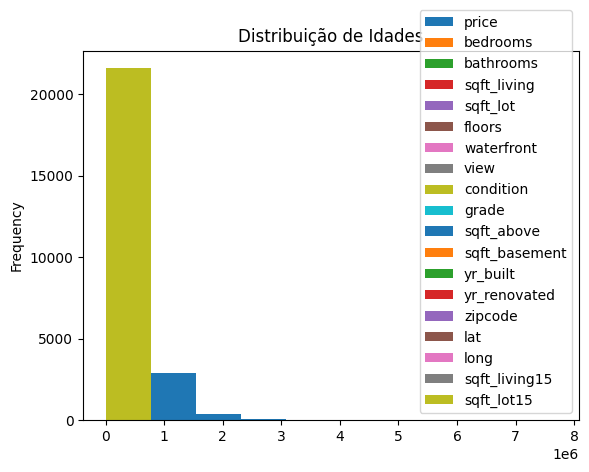

In [61]:
sales.plot(kind='hist', title='Distribuição de Idades')
# sales[colu]
plt.show()

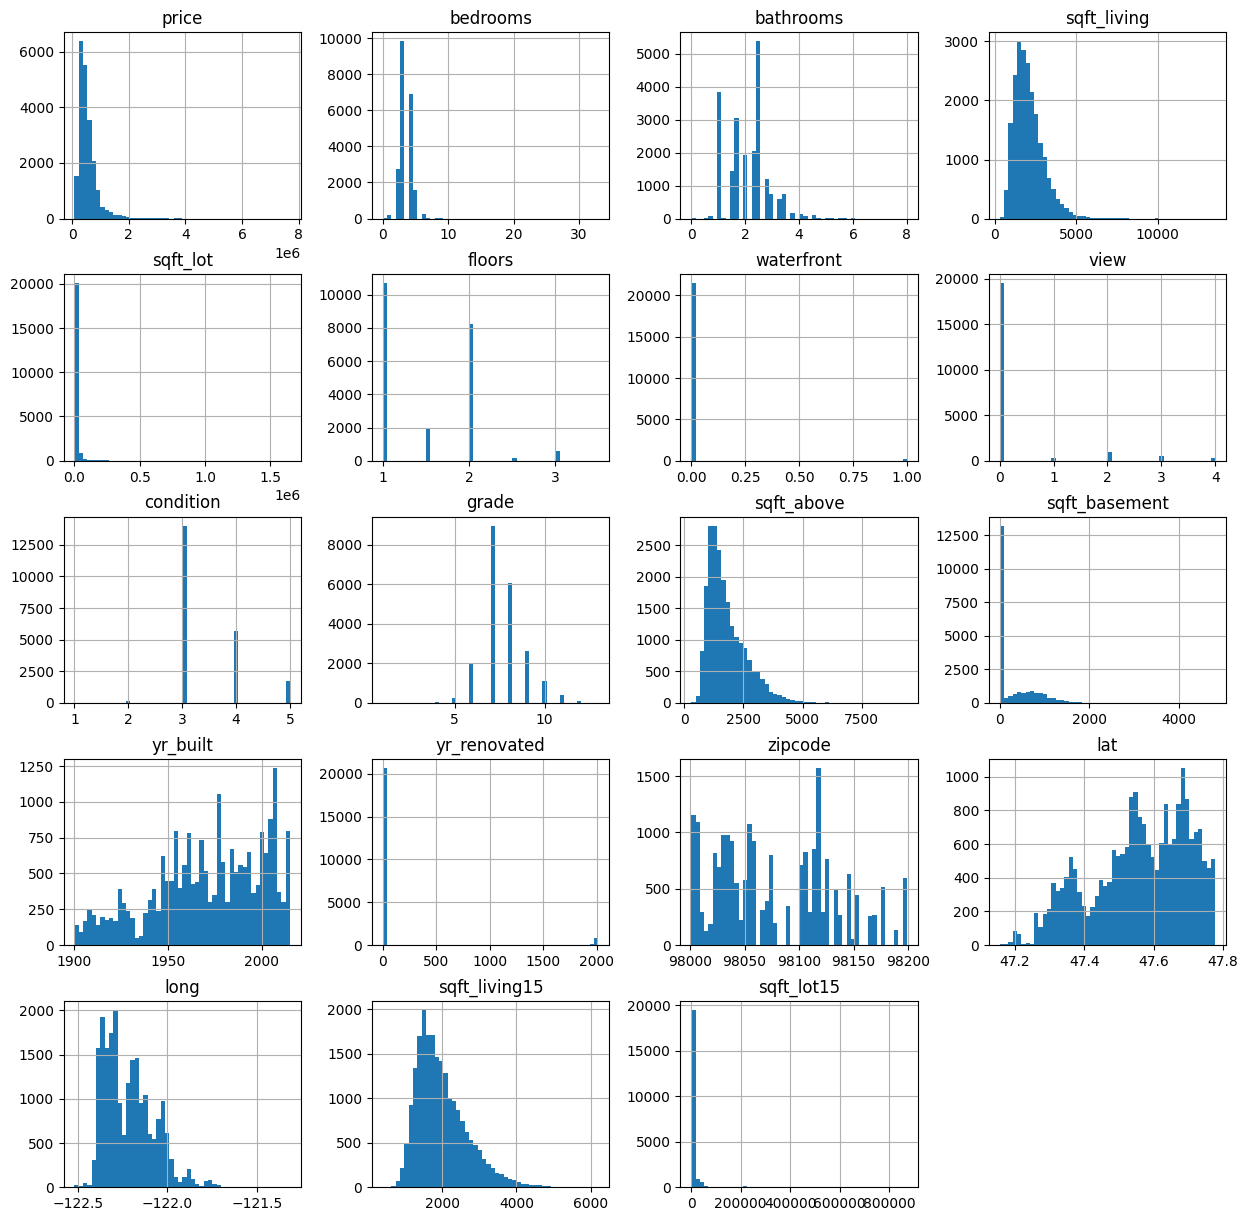

In [62]:
columns = sales.columns.tolist()
sales[columns].hist(bins=50, figsize=[15,15])
plt.show()


In [63]:
# for col in sales[columns]:
#     sales.plot.scatter(x=col, y='price', tible='Scatter Plot of' + col + 'and price')


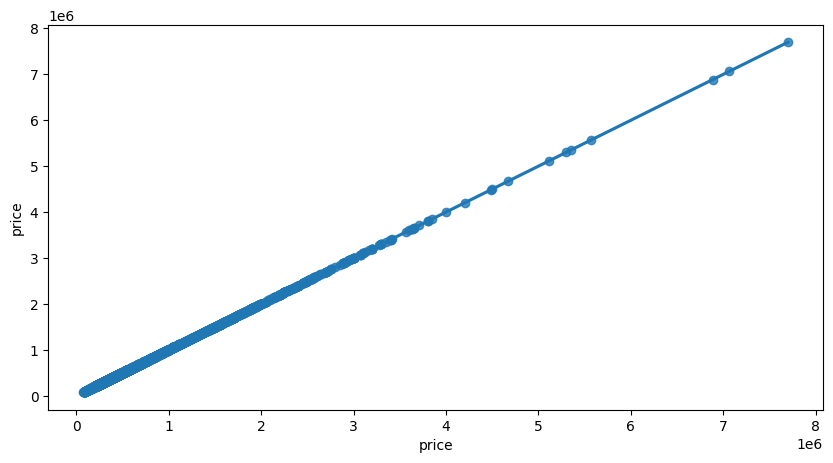

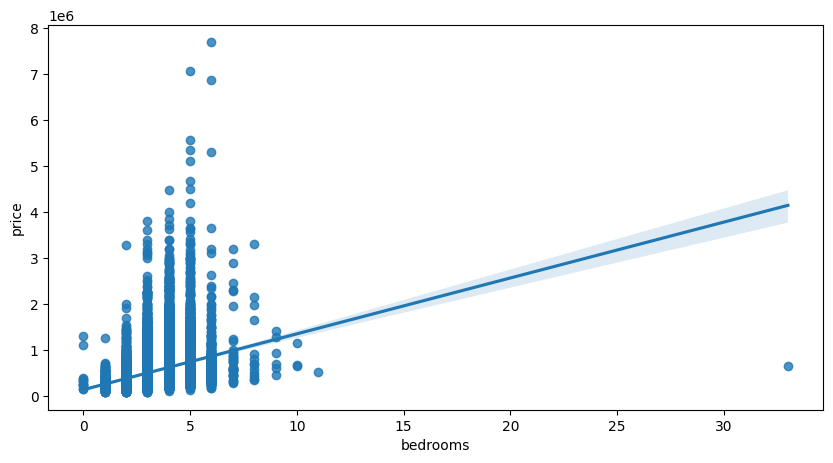

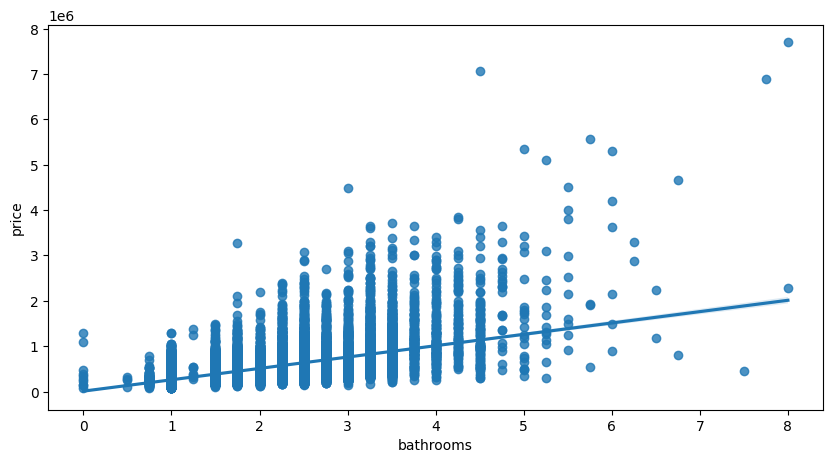

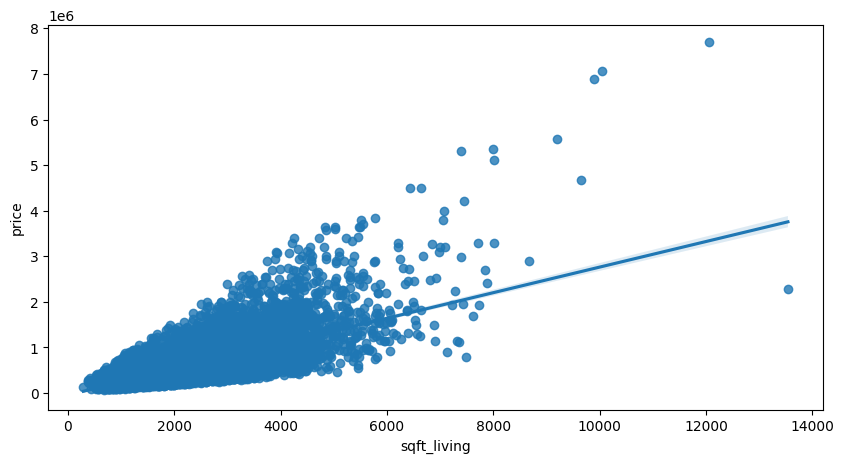

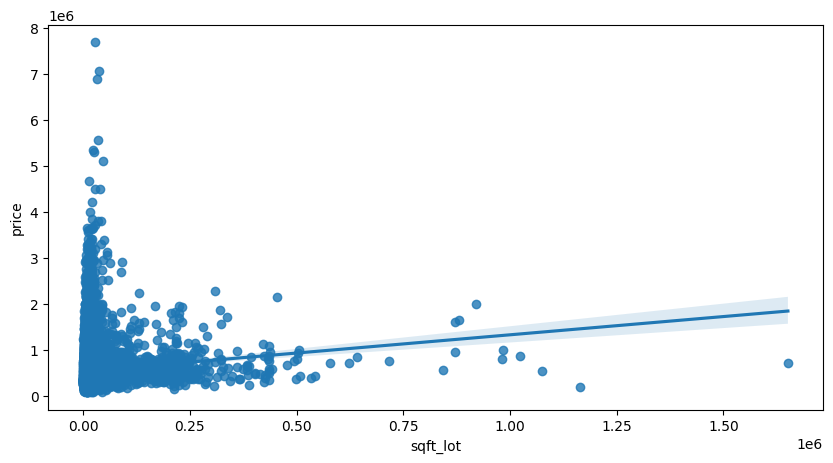

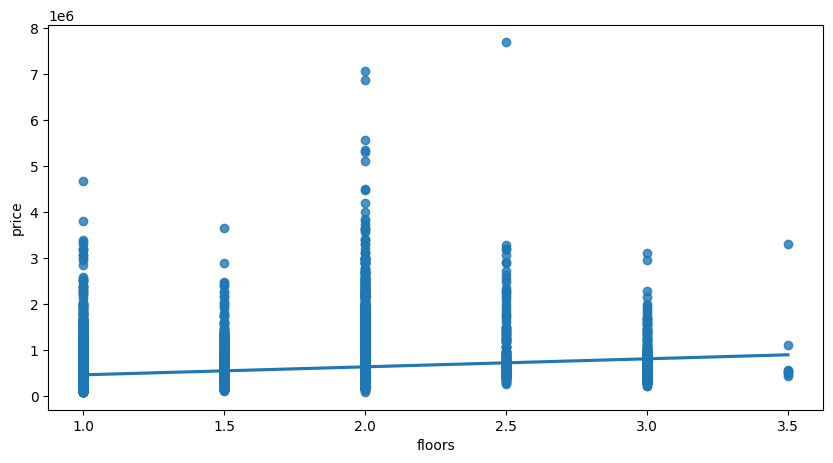

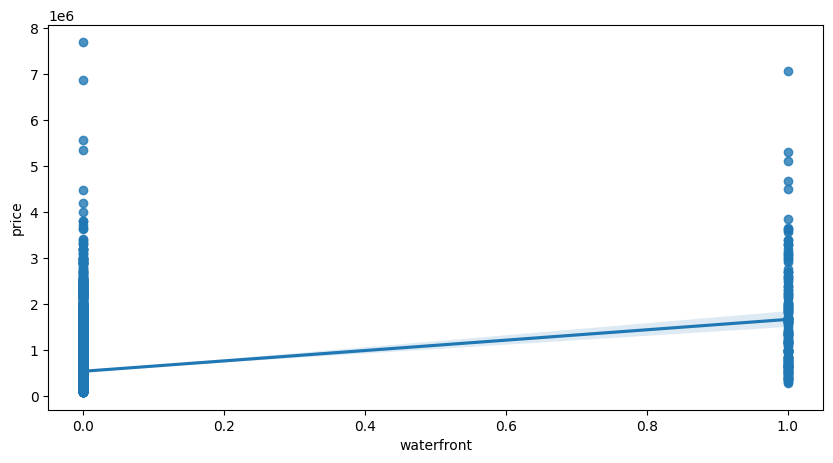

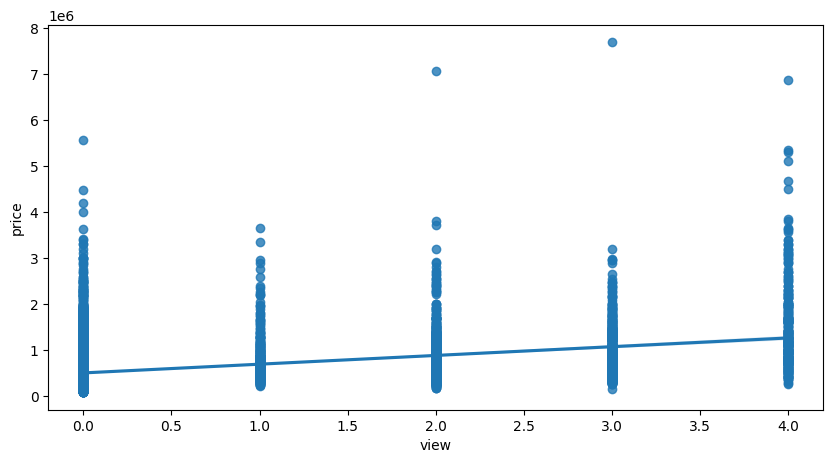

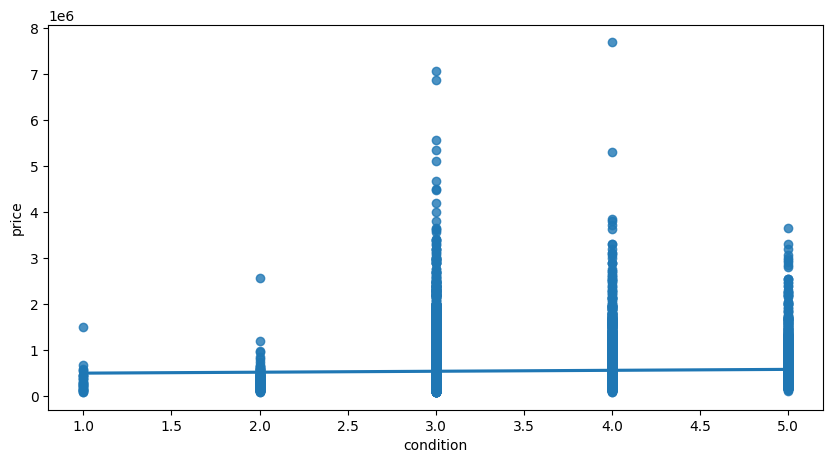

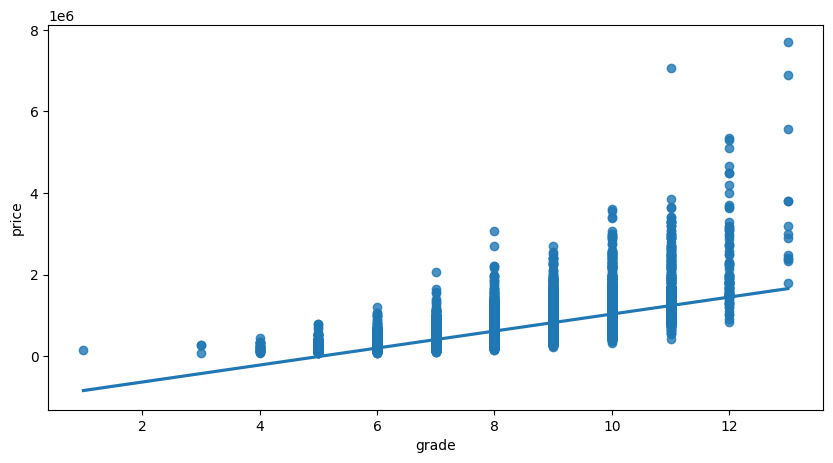

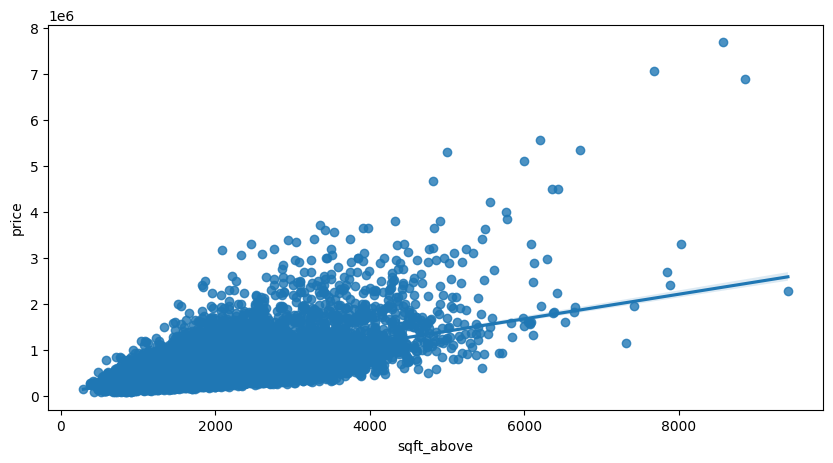

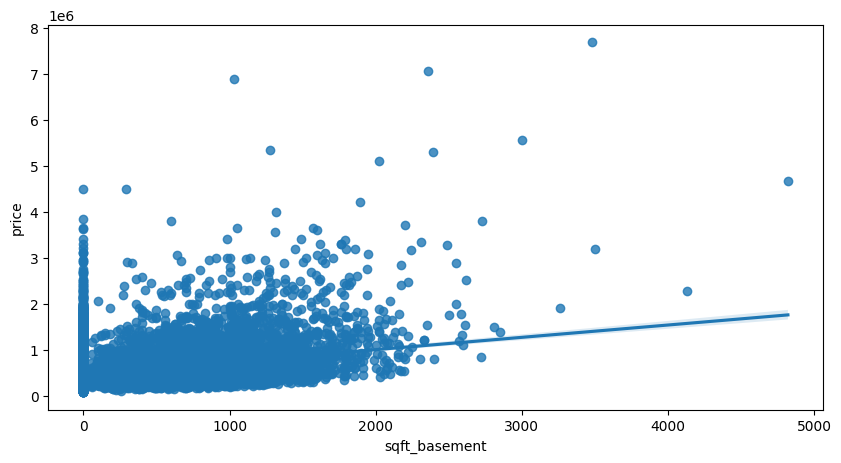

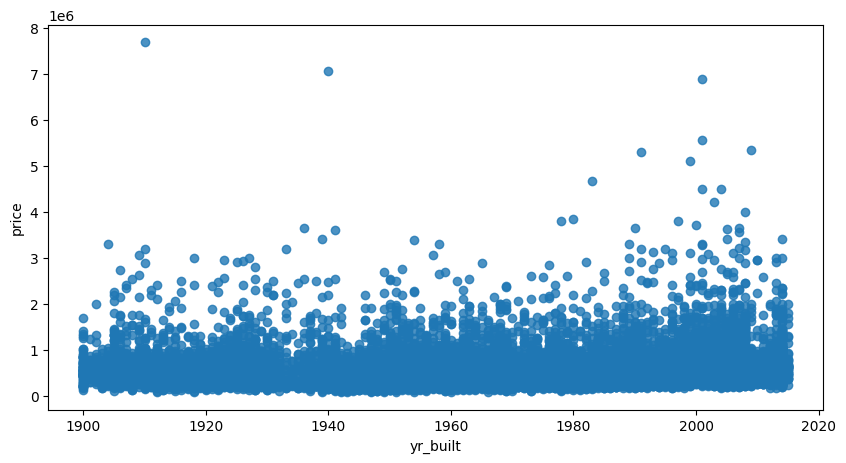

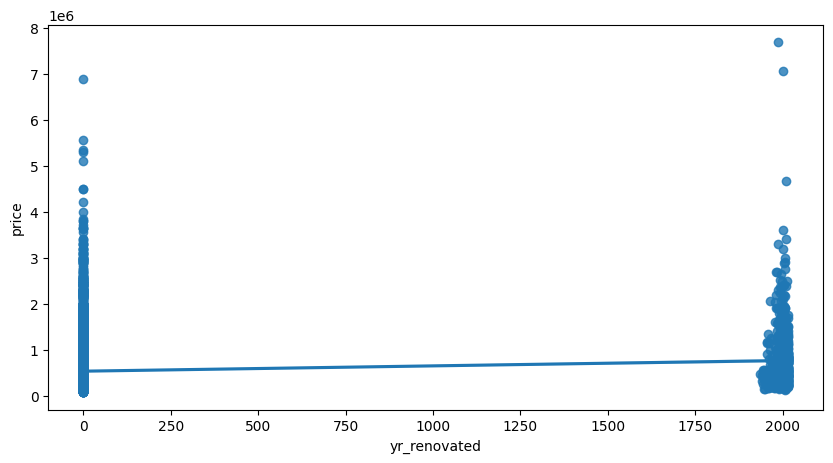

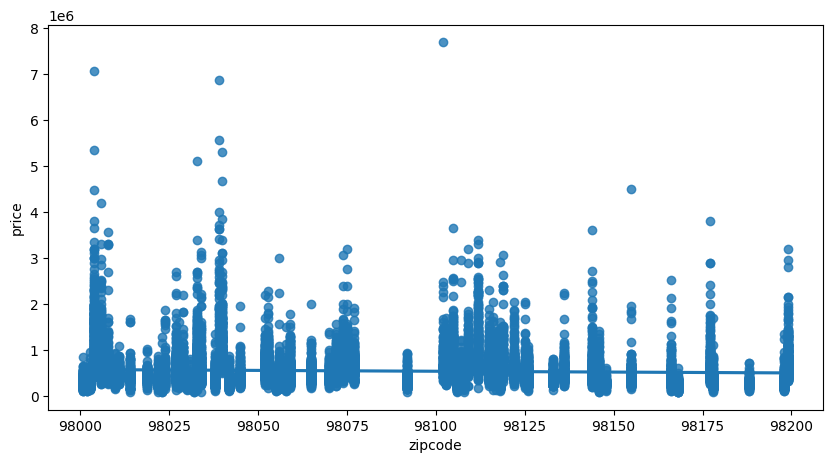

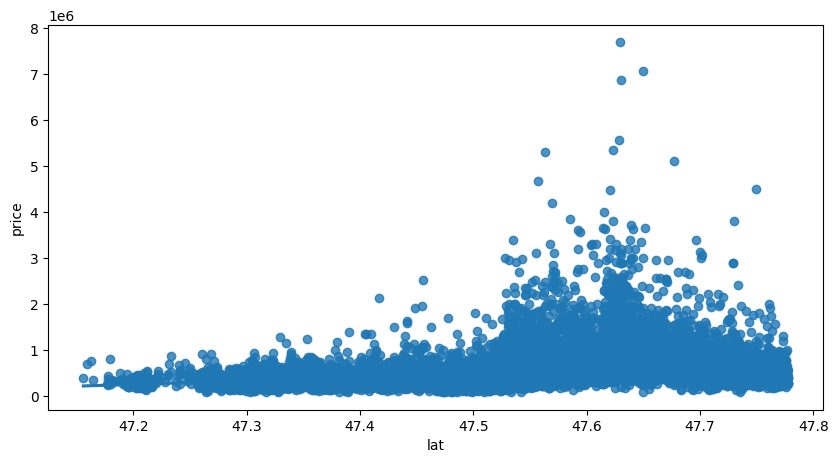

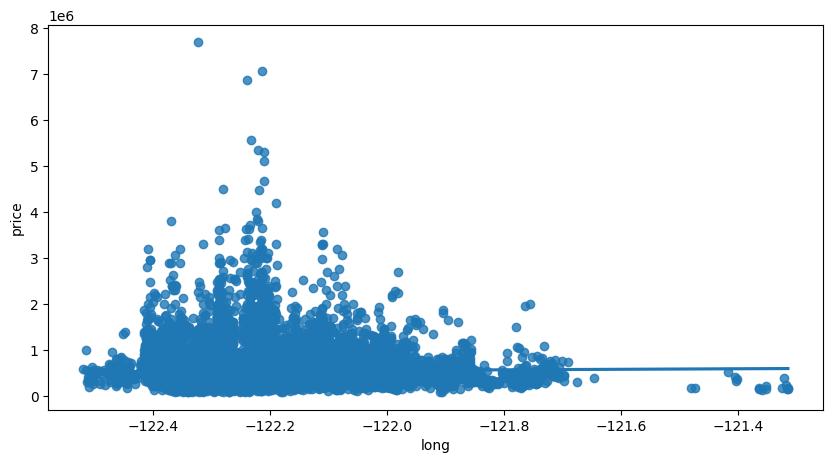

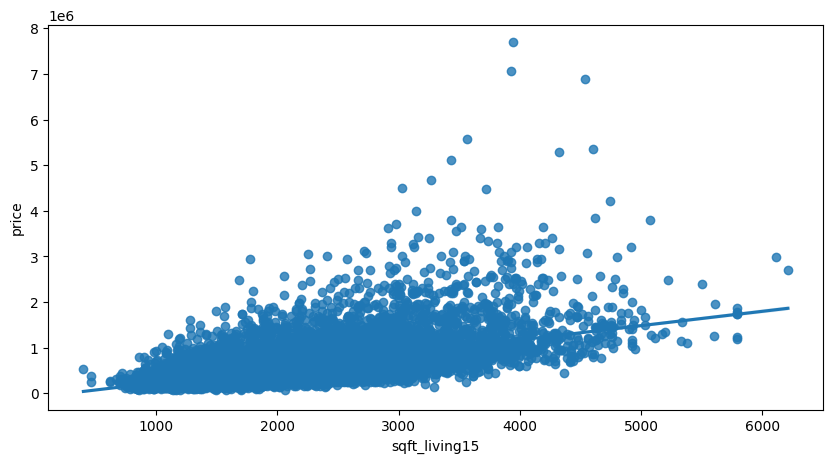

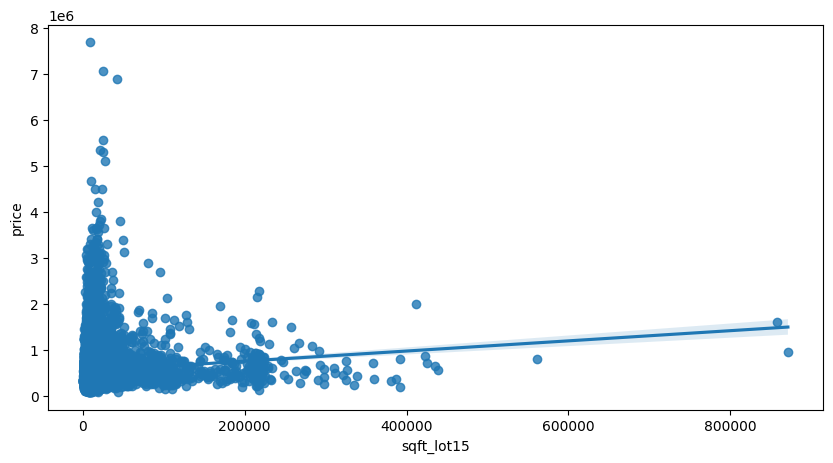

In [64]:

for col in sales[columns]:
    plt.figure(figsize=(10,5))
    sns.regplot(data=sales[columns], x=col, y='price')
    plt.xlabel(col)
    plt.ylabel('price')